In [1]:
import torchvision
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from network_class import *
from sequence_dataset import *
from utils import *


## hypers

In [2]:
# %%
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# set seed
torch.manual_seed(999)

# network hypers
adap_neuron = True  # whether use adaptive neuron or not
dp = 0.2
onetoone = True
num_readout = 10

# seq data set config
seq_len = 40  # sequence length
random_switch = False  # predictable or random switch time
switch_time = [seq_len / 2]  # if not random switch, provide switch time
num_switch = 1  # used when random switch=T

n_classes = 10

cuda


## load test data and model


In [3]:
###############################################################
# IMPORT DATASET
###############################################################

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 200

testdata = torchvision.datasets.MNIST(root='./data', train=False,
                                      download=True, transform=transform)

seq_test = SequenceDatasetPredictable(testdata, testdata.targets, seq_len, random_switch,
                           switch_time, num_switch)

test_loader = torch.utils.data.DataLoader(seq_test, batch_size=batch_size,
                                          shuffle=False, num_workers=3)

for batch_idx, (data, target) in enumerate(test_loader):
    print(data.shape)
    print(target.shape)
    break


num of sequences created: 10000
torch.Size([200, 40, 28, 28])
torch.Size([200, 40])


In [4]:
# ##############################################################
# DEFINE NETWORK
# ##############################################################

# set input and t param
IN_dim = 784
hidden_dim = [10 * num_readout, 784]

# define network
model = SnnNetworkSeq(IN_dim, hidden_dim, n_classes, is_adapt=adap_neuron, one_to_one=onetoone,
                      dp_rate=dp)
model.to(device)
print(model)

# define new loss and optimiser
total_params = count_parameters(model)
print('total param count %i' % total_params)


SnnNetworkSeq(
  (dp): Dropout(p=0.2, inplace=False)
  (r_in_rec): SnnLayer(
    (rec_w): Linear(in_features=784, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
  (rin2rout): Linear(in_features=784, out_features=100, bias=True)
  (rout2rin): Linear(in_features=100, out_features=784, bias=True)
  (r_out_rec): SnnLayer(
    (rec_w): Linear(in_features=100, out_features=100, bias=True)
    (sigmoid): Sigmoid()
  )
  (output_layer): OutputLayer(
    (sigmoid): Sigmoid()
  )
)
total param count 785886


In [5]:
exp_dir = '/home/lucy/spikingPC/results/Feb-15-2023/fptt_ener_fpttalpha02_randswitchp0.0/'
saved_dict = model_result_dict_load(exp_dir + 'onelayer_rec_best.pth.tar')

model.load_state_dict(saved_dict['state_dict'])
model.eval()

SnnNetworkSeq(
  (dp): Dropout(p=0.2, inplace=False)
  (r_in_rec): SnnLayer(
    (rec_w): Linear(in_features=784, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
  (rin2rout): Linear(in_features=784, out_features=100, bias=True)
  (rout2rin): Linear(in_features=100, out_features=784, bias=True)
  (r_out_rec): SnnLayer(
    (rec_w): Linear(in_features=100, out_features=100, bias=True)
    (sigmoid): Sigmoid()
  )
  (output_layer): OutputLayer(
    (sigmoid): Sigmoid()
  )
)

In [6]:
# get params and put into dict
param_names = []
param_dict = {}
for name, param in model.named_parameters():
    if param.requires_grad:
        param_names.append(name)
        param_dict[name] = param.detach().cpu().numpy()

print(param_names)

['r_in_rec.tau_adp', 'r_in_rec.tau_m', 'r_in_rec.tau_i', 'r_in_rec.rec_w.weight', 'r_in_rec.rec_w.bias', 'rin2rout.weight', 'rin2rout.bias', 'rout2rin.weight', 'rout2rin.bias', 'r_out_rec.tau_adp', 'r_out_rec.tau_m', 'r_out_rec.tau_i', 'r_out_rec.rec_w.weight', 'r_out_rec.rec_w.bias', 'output_layer.tau_m']


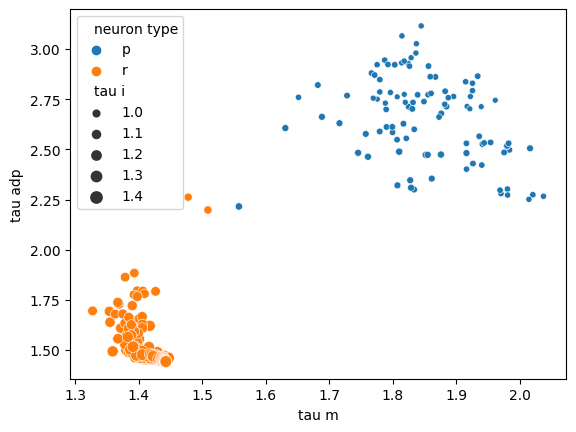

In [37]:
def get_real_constants(pseudo_constants):
    return -1/np.log(1/(1 + np.exp(-pseudo_constants)))

# time constants 
constants = {
    'neuron type': ['p']*100 + ['r']*784, 
    'tau m': get_real_constants(np.concatenate((model.r_out_rec.tau_m.detach().cpu().numpy().flatten(), model.r_in_rec.tau_m.detach().cpu().numpy().flatten()))), 
    'tau adp': get_real_constants(np.concatenate((model.r_out_rec.tau_adp.detach().cpu().numpy().flatten(), model.r_in_rec.tau_adp.detach().cpu().numpy().flatten()))), 
    'tau i': get_real_constants(np.concatenate((model.r_out_rec.tau_i.detach().cpu().numpy().flatten(), model.r_in_rec.tau_i.detach().cpu().numpy().flatten()))), 
}

df_constants = pd.DataFrame.from_dict(constants)

sns.scatterplot(df_constants, x='tau m', y='tau adp', hue='neuron type', size='tau i')
plt.show()

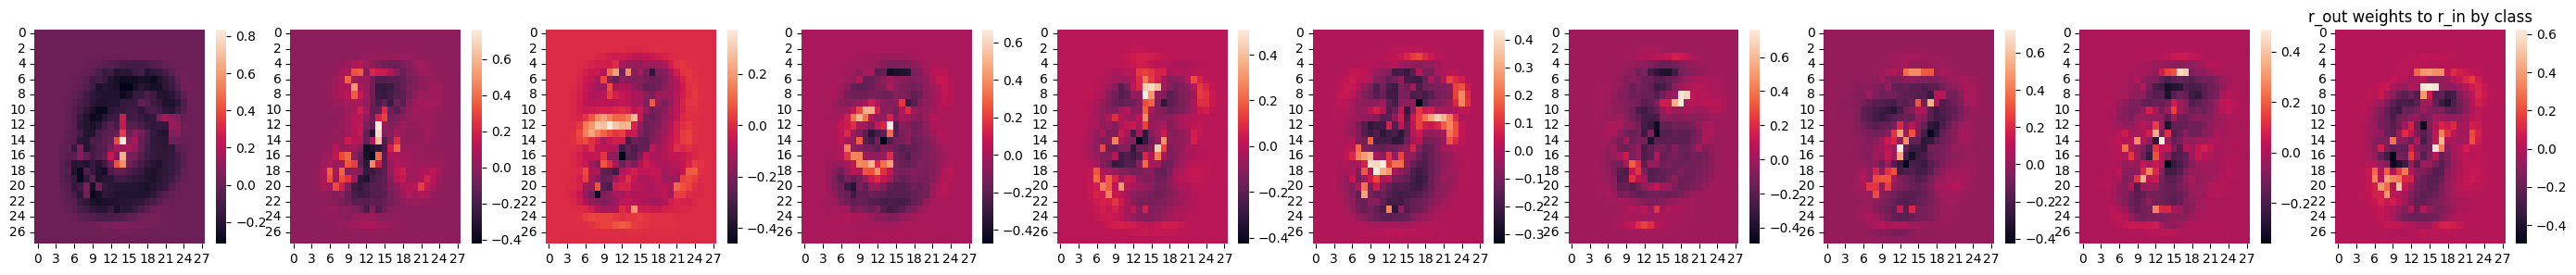

In [7]:
# %%
# plot p to r weights
fig, axs = plt.subplots(1, 10, figsize=(35, 3))
for i in range(10):
    sns.heatmap(
        model.rout2rin.weight[:, num_readout * i:(i + 1) * num_readout].detach().cpu().numpy().sum(axis=1).reshape(28,
                                                                                                                   28),
        ax=axs[i])
plt.title('r_out weights to r_in by class')

plt.show()
# plt.savefig(exp_dir + 'r_out weights to r_in by class')
# plt.close()

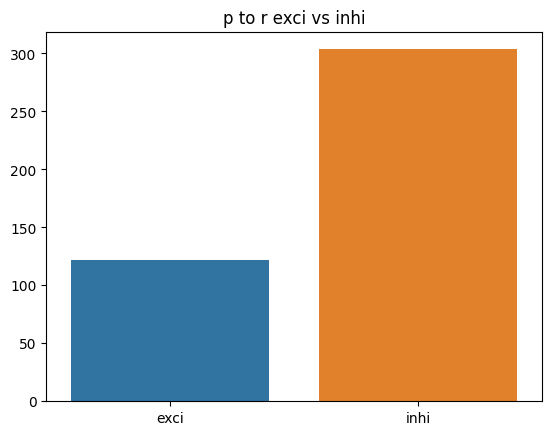

In [8]:
# plot p to r exci vs inhi
fig = plt.figure()
x = ['exci', 'inhi']
p2r_w = model.rout2rin.weight
y = [(p2r_w * (p2r_w > 0)).detach().cpu().numpy().sum(), -(p2r_w * (p2r_w < 0)).detach().cpu().numpy().sum()]
sns.barplot(x=x, y=y)
plt.title('p to r exci vs inhi')
plt.show()

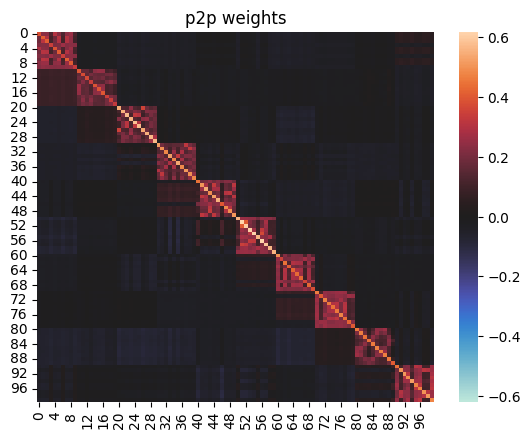

In [9]:
# weight matrix for p2p

fig = plt.figure()
abs_max = np.max(np.abs(model.r_out_rec.rec_w.weight.detach().cpu().numpy()))
sns.heatmap(model.r_out_rec.rec_w.weight.detach().cpu().numpy(), vmax=abs_max, vmin=-abs_max, cmap='icefire')
plt.title('p2p weights')
plt.show()
# plt.savefig(exp_dir + 'p2p weights')
# plt.close()

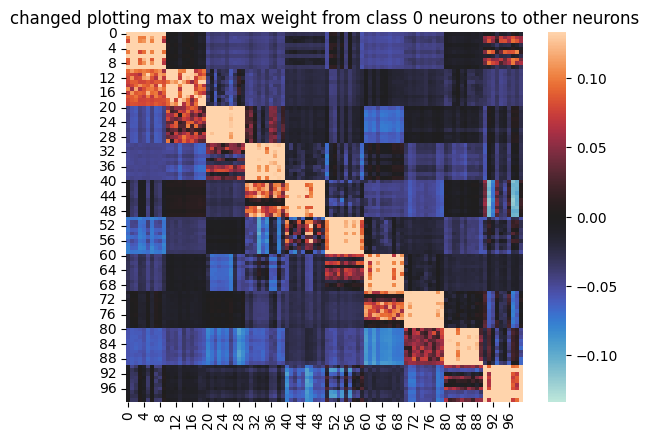

In [19]:
# examine weight matrix from 0 to 1 vs 0 to other classes
fig = plt.figure()
abs_max = np.max(np.abs(model.r_out_rec.rec_w.weight[10:, :10].detach().cpu().numpy()))
sns.heatmap(model.r_out_rec.rec_w.weight.detach().cpu().numpy(), vmax=abs_max, vmin=-abs_max, cmap='icefire')
plt.title('changed plotting max to max weight from class 0 neurons to other neurons')
plt.show()

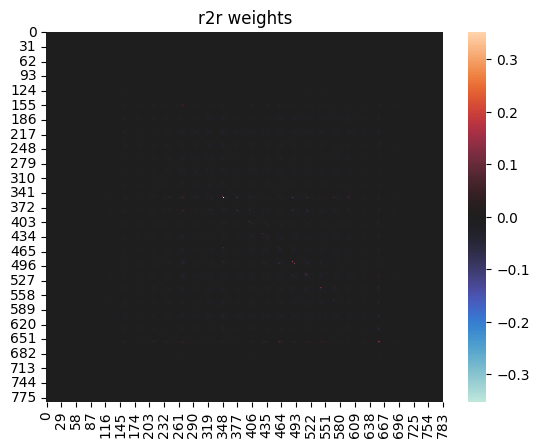

In [11]:
# weight matrix for r2r

fig = plt.figure()
abs_max = np.max(np.abs(model.r_in_rec.rec_w.weight.detach().cpu().numpy()))
sns.heatmap(model.r_in_rec.rec_w.weight.detach().cpu().numpy(), vmax=abs_max, vmin=-abs_max, cmap='icefire')
plt.title('r2r weights')
plt.show()

(784,)


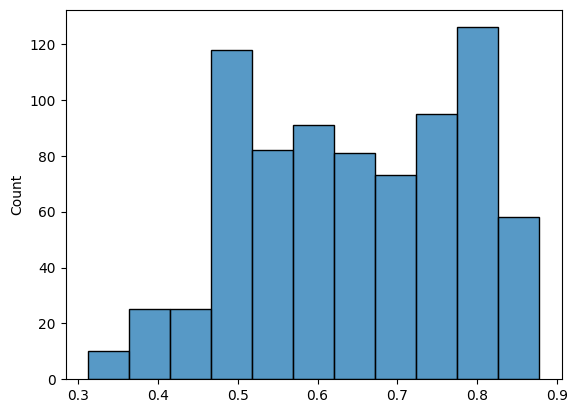

In [12]:
mean_exci_w = ((model.r_in_rec.rec_w.weight>0).float()).mean(dim=1).detach().cpu().numpy()
mean_inhi_w = ((model.r_in_rec.rec_w.weight<0).float()).mean(dim=1).detach().cpu().numpy()
print(mean_exci_w.shape)
sns.histplot(mean_inhi_w)
plt.show()

In [7]:
def save_to_cpu(hidden_):
    for i in range(len(hidden_)):
        hidden_[i] = list(hidden_[i])
        for j in range(len(hidden_[0])):
            hidden_[i][j] = hidden_[i][j].cpu()

    return hidden_

def get_all_data(model, test_loader, onlyshowone=None):
    #  get all analysis data in sequence condition
    test_loss = 0
    correct = 0
    correct_end_of_seq = 0

    hiddens_all = []
    predictions_all = []
    targets_all = []

    # for data, target in test_loader:
    for i, (data, target) in enumerate(test_loader):
        targets_all.append(target)
        data, target = data.to(device), target.to(device)
        data = data.view(-1, seq_len, model.in_dim)
        if onlyshowone:
            data[:, onlyshowone:, :] = -1

        with torch.no_grad():
            model.eval()
            hidden = model.init_hidden(data.size(0))

            log_softmax_outputs, hidden, pred_hist = model.inference(data, hidden, seq_len)
            hiddens_all.append(save_to_cpu(hidden))
            predictions_all.append(pred_hist.T)

            # compute loss at each time step
            for t in range(seq_len):
                test_loss += F.nll_loss(log_softmax_outputs[t], target[:, t], reduction='sum').data.item()

        correct += pred_hist.T.eq(target.data).cpu().sum()
        # only check end of sequence acc 
        correct_end_of_seq += pred_hist.T[:, int(seq_len / 2) - 1].eq(target[:, int(seq_len / 2) - 1].data).cpu().sum()
        correct_end_of_seq += pred_hist.T[:, seq_len - 1].eq(target[:, seq_len - 1].data).cpu().sum()
        torch.cuda.empty_cache()

    test_loss /= len(test_loader.dataset)  # per t loss
    test_acc = 100. * correct / len(test_loader.dataset) / seq_len
    test_acc_endofseq = 100 * correct_end_of_seq / len(test_loader.dataset) / 2

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), End of seq acc: {:.2f}%\n'.format(
        test_loss, int(correct / seq_len), len(test_loader.dataset),
        test_acc, test_acc_endofseq))

    predictions_all = torch.stack(predictions_all).reshape(test_loader.dataset.num_samples, seq_test.seq_len).cpu()
    targets_all = torch.stack(targets_all).reshape(test_loader.dataset.num_samples, seq_test.seq_len).cpu()

    return hiddens_all, targets_all, predictions_all


In [8]:
hiddens_all, targets_all, predictions_all = get_all_data(model, test_loader=test_loader)


Test set: Average loss: 32.5731, Accuracy: 7863/10000 (79%), End of seq acc: 90.11%



## error neurons as those spiking to difference between class c and c+1 

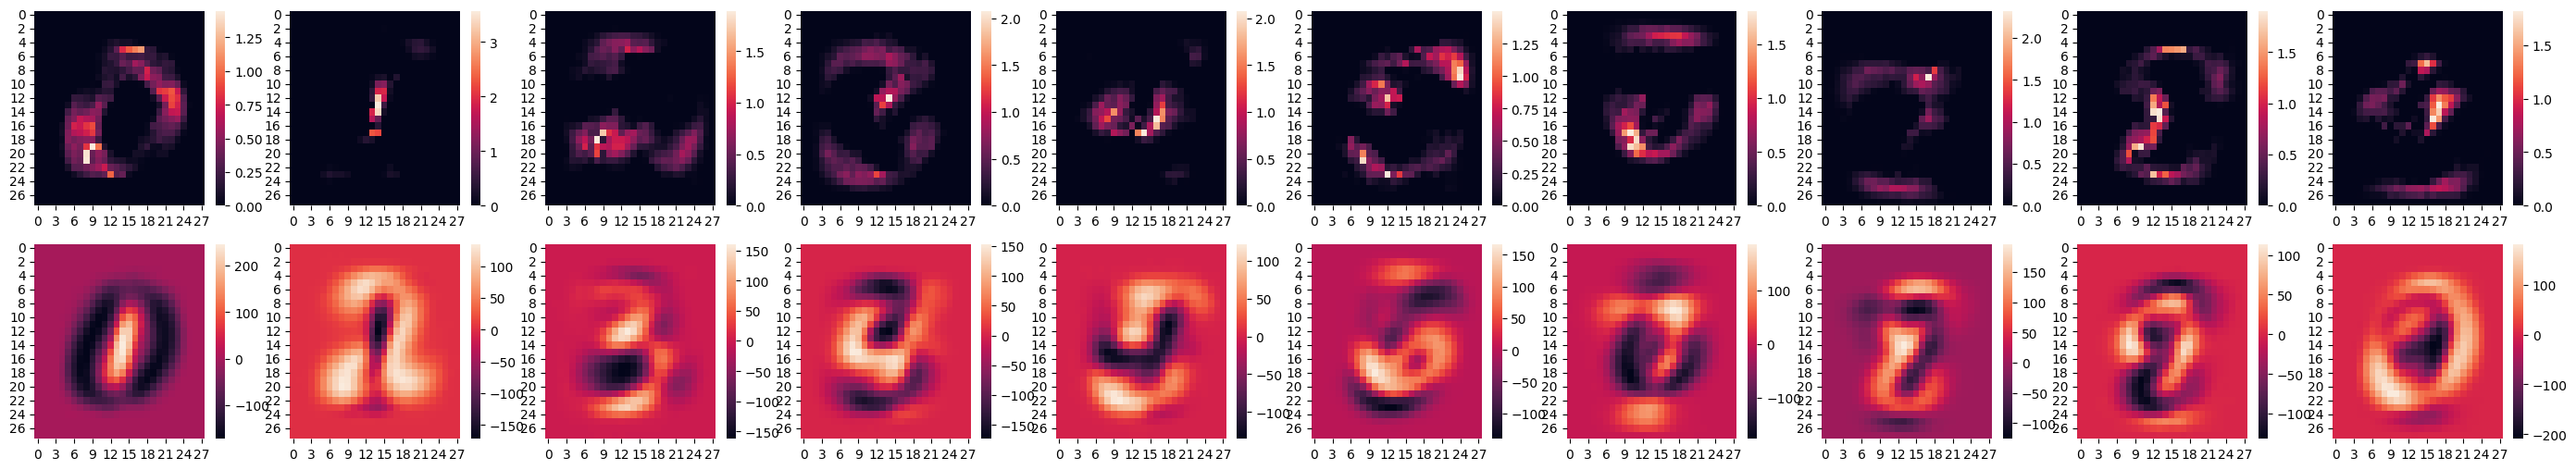

In [16]:
r2p_w = model.rin2rout.weight.detach().cpu().numpy()

fig, axs = plt.subplots(2, 10, figsize=(35, 6))
for i in range(10):
    sns.heatmap(((r2p_w[i*10: (i+1)*10, :]>0)*r2p_w[i*10: (i+1)*10, :]).sum(axis=0).reshape(28, 28), ax=axs[0, i])
    if i!=9: 
        class_diff_img = seq_test.image_data.data[seq_test.label_data==(i+1)].float().mean(dim=0) - seq_test.image_data.data[seq_test.label_data==i].float().mean(dim=0)
    else:
        class_diff_img = seq_test.image_data.data[seq_test.label_data==0].float().mean(dim=0) - seq_test.image_data.data[seq_test.label_data==i].float().mean(dim=0)
    sns.heatmap(class_diff_img.numpy(), ax=axs[1, i])
plt.show()

## spk rate of error neurons during first steps of inference vs when rep of p has stablised 

In [28]:
idx_error_neurons0


(array([  3,   7,  10,  11,  13,  14,  17,  19,  20,  21,  22,  28,  32,
         34,  53,  54,  55,  57,  58,  59,  60,  61,  82,  84,  85,  86,
         88, 112, 113, 115, 123, 124, 125, 126, 127, 128, 143, 151, 152,
        153, 154, 155, 156, 157, 158, 159, 160, 168, 169, 178, 179, 180,
        181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 197, 206, 207,
        208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 224, 234,
        235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
        262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274,
        275, 289, 290, 291, 292, 293, 297, 298, 299, 300, 301, 302, 303,
        304, 308, 315, 316, 317, 318, 319, 320, 327, 328, 329, 330, 331,
        332, 336, 342, 343, 344, 345, 346, 347, 348, 355, 356, 357, 358,
        359, 360, 361, 364, 369, 370, 371, 372, 373, 374, 375, 376, 384,
        385, 386, 387, 388, 389, 392, 397, 398, 399, 400, 401, 402, 403,
        412, 413, 414, 415, 416, 417, 419, 421, 425

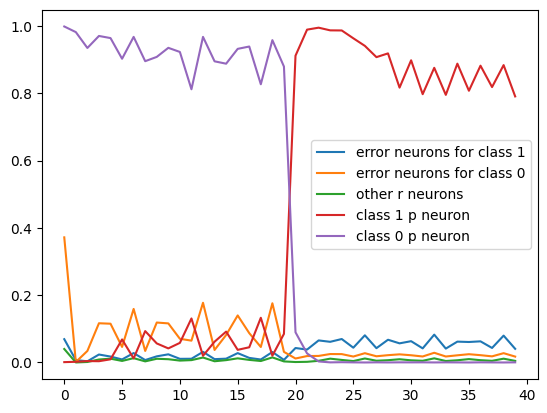

In [30]:
# for class 0 to 1 
r_spk_all_class0 = get_states(hiddens_all, 1, hidden_dim[1], batch_size, T=40)[seq_test.label_data==0]
idx_error_neurons1 = np.nonzero((r2p_w[10: 20, :]).sum(axis=0)>0)[0]
idx_error_neurons0 = np.nonzero((r2p_w[0:10, :]).sum(axis=0)>0)[0]

r_spk_error1 = r_spk_all_class0[:, :, idx_error_neurons1].squeeze()
r_spk_error0 = r_spk_all_class0[:, :, idx_error_neurons0].squeeze()

r_spk_rest = np.delete(r_spk_all_class0, np.concatenate((idx_error_neurons0, idx_error_neurons1)), axis=-1)

# p neurons spks
p_spk_all_class0 = get_states(hiddens_all, 5, hidden_dim[0], batch_size, T=40)[seq_test.label_data==0]
p_spk1 = p_spk_all_class0[:, :, 10:20].mean(axis=0).mean(axis=1)
p_spk0 = p_spk_all_class0[:, :, 0:10].mean(axis=0).mean(axis=1)


plt.plot(np.arange(seq_len), r_spk_error1.mean(axis=0).mean(axis=1), label='error neurons for class 1')
plt.plot(np.arange(seq_len), r_spk_error0.mean(axis=0).mean(axis=1), label='error neurons for class 0')
plt.plot(np.arange(seq_len), r_spk_rest.mean(axis=0).mean(axis=1), label='other r neurons')
plt.plot(np.arange(seq_len), p_spk1, label='class 1 p neuron')
plt.plot(np.arange(seq_len), p_spk0, label='class 0 p neuron')

plt.legend()
plt.show()

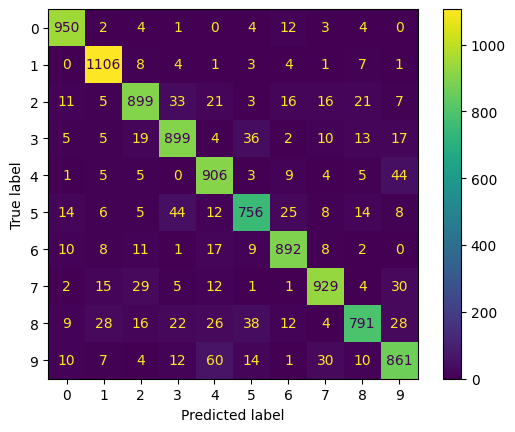

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(targets_all[:, 19], predictions_all[:, 19])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=np.arange(10))
disp.plot()

plt.show()

In [16]:
# spike rate of each class of neuron per class image 
spk_p = get_states(hiddens_all, 5, hidden_dim[0], batch_size, T=40, num_samples=seq_test.num_samples)


(10000, 100)


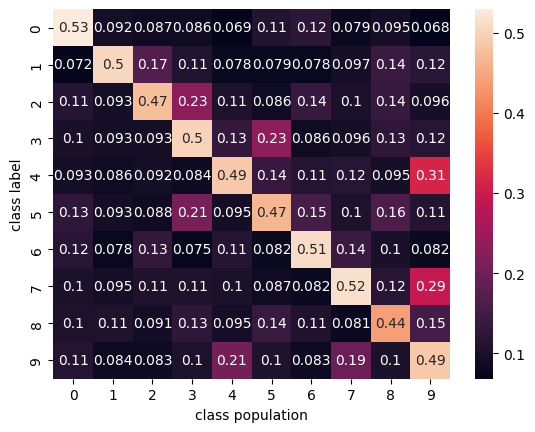

In [18]:
spk_p_rate_stim1 = spk_p[:, :int(seq_len/2), :].mean(axis=1)
spk_p_rate_stim2 = spk_p[:, int(seq_len/2):, :].mean(axis=1)
print(spk_p_rate_stim1.shape)

spk_p_perclass = np.zeros((n_classes, n_classes))

for i in range(n_classes):  # class of stimuli
    for p in range(n_classes): # populations of neuron 
        spk_p_perclass[i, p] = spk_p_rate_stim1[targets_all[:, 0]==i, p*10:(p+1)*10].mean() / 2 + spk_p_rate_stim1[targets_all[:, 1]==i].mean()/2

fig = plt.figure()
sns.heatmap(spk_p_perclass, annot=True)
plt.xlabel('class population')
plt.ylabel('class label')
plt.show()

(10000, 40, 784)
(10000, 40, 100)


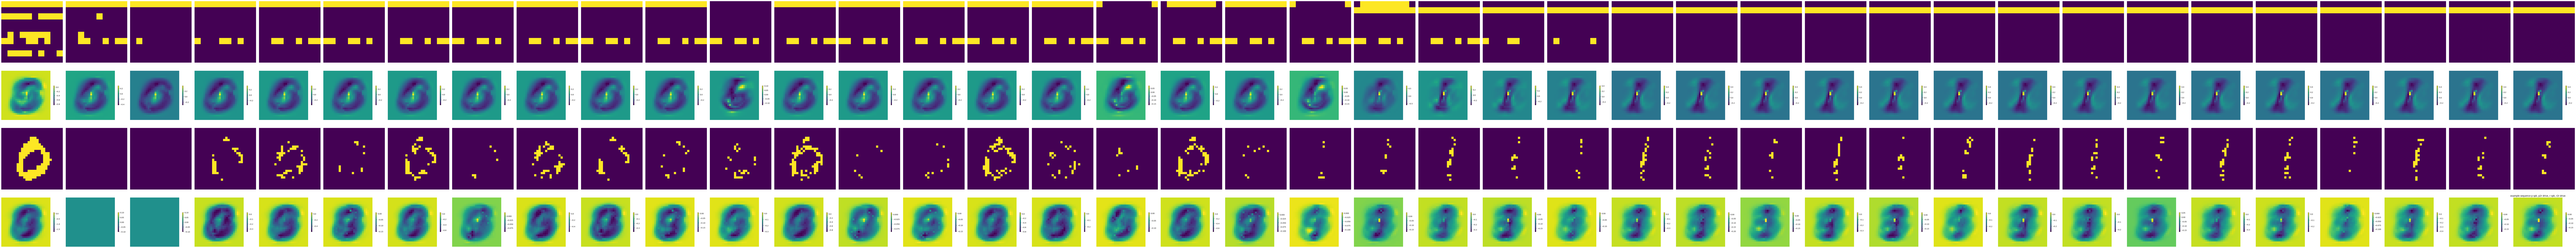

In [ ]:
# get spks from r and p for plotting a sequence
r_spk_all = get_states(hiddens_all, 1, hidden_dim[1], batch_size, T=40)
p_spk_all = get_states(hiddens_all, 5, hidden_dim[0], batch_size, T=40)

# get necessary weights
p2r_w = model.rout2rin.weight.detach().cpu().numpy()
r_rec_w = model.r_in_rec.rec_w.weight.detach().cpu().numpy()

print(r_spk_all.shape)
print(p_spk_all.shape)

# plot example seq
sample_no = 3
fig, axs = plt.subplots(4, 40, figsize=(200, 20))  # p spiking, r spiking, rec drive from p, rec drive from r
# axs[0].imshow(images[sample_no, :, :])
# axs[0].set_title('class %i, prediction %i' % (target_all[sample_no], preds_all[sample_no]))
for t in range(seq_len):
    # p spiking
    axs[0][t].imshow(p_spk_all[sample_no, t, :].reshape(10, int(hidden_dim[0] / 10)))
    axs[0][t].axis('off')

    # drive from p to r
    pos1 = axs[1][t].imshow((p2r_w @ p_spk_all[sample_no, t, :]).reshape(28, 28))
    fig.colorbar(pos1, ax=axs[1][t], shrink=0.3)
    axs[1][t].axis('off')

    # r spiking
    axs[2][t].imshow(r_spk_all[sample_no, t, :].reshape(28, 28))
    axs[2][t].axis('off')

    # drive from r to r
    pos2 = axs[3][t].imshow((r_rec_w @ r_spk_all[sample_no, t, :]).reshape(28, 28))
    fig.colorbar(pos2, ax=axs[3][t], shrink=0.3)
    axs[3][t].axis('off')

plt.title('example sequence p spk, p2r drive, r spk, r2r drive')
plt.tight_layout()
plt.show()

## exp with not presenting stimulus starting t=15 but running inference

In [12]:
# let inference run but no input in second half to see if prediction neurons fire anyways 
sample_img, _ = testdata[3]
stimulus = torch.concatenate((sample_img.repeat(15, 1, 1), torch.full((25, 28, 28), -1)))
stimulus.size()

torch.Size([40, 28, 28])

In [13]:
with torch.no_grad():
    model.eval()
    hidden = model.init_hidden(stimulus.view(-1, seq_len, IN_dim).size(0))

    _, hidden, _ = model.inference(stimulus.view(-1, seq_len, IN_dim).to(device), hidden, seq_len)


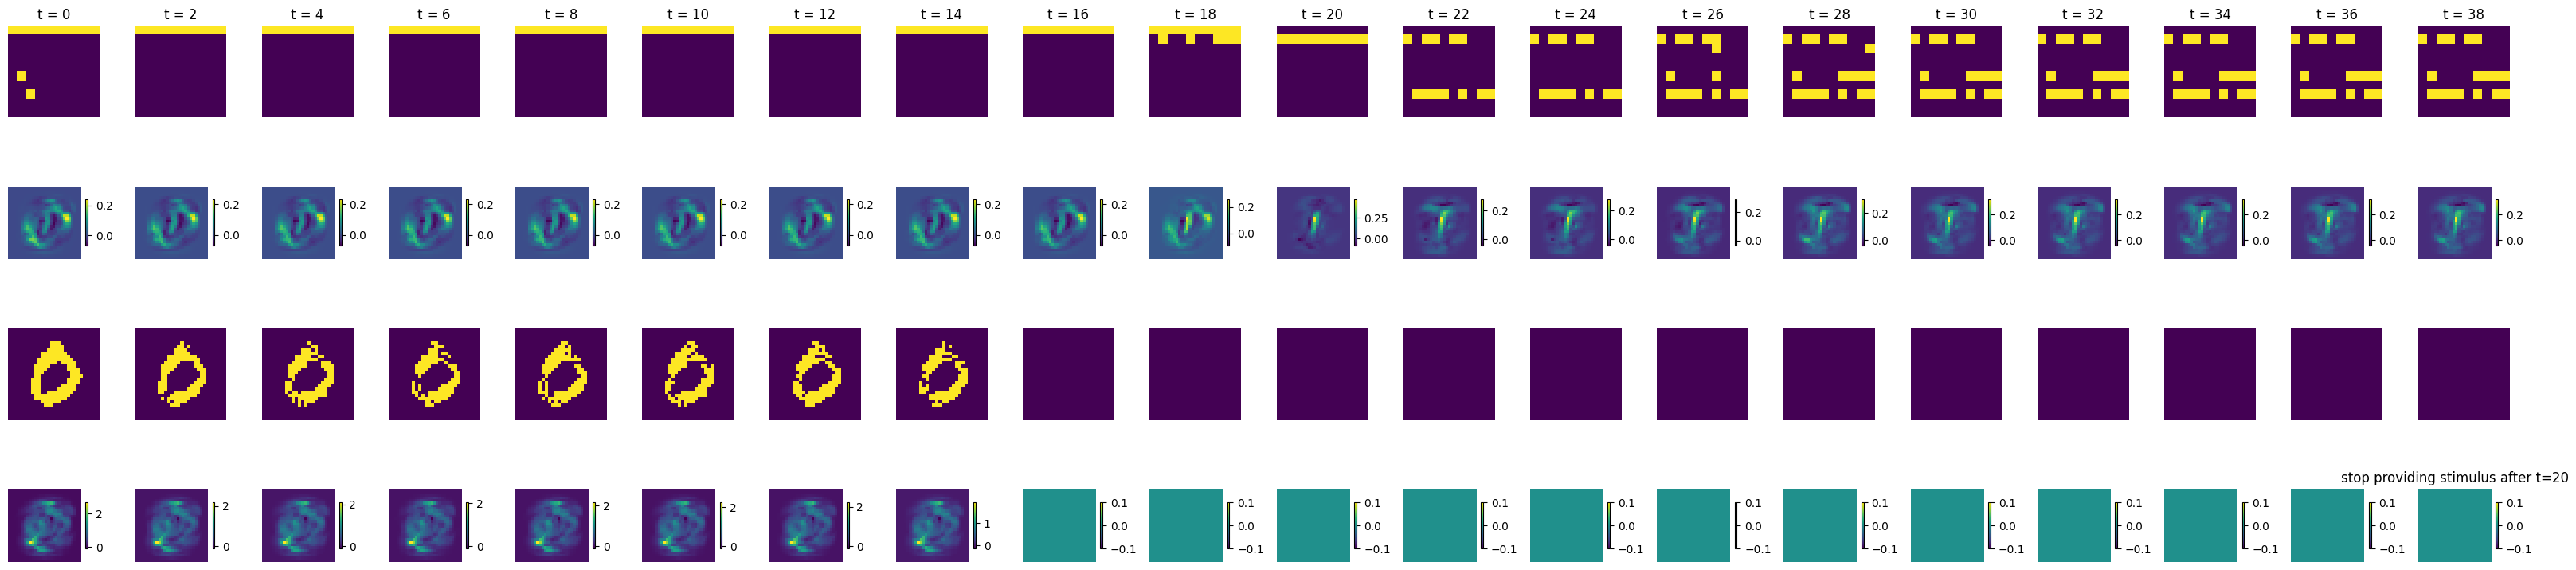

In [14]:
# get necessary weights
p2r_w = model.rout2rin.weight.detach().cpu().numpy()
r_rec_w = model.r_in_rec.rec_w.weight.detach().cpu().numpy()

fig, axs = plt.subplots(4, 20, figsize=(32, 8))  # p spiking, r spiking, rec drive from p, rec drive from r
# axs[0].imshow(images[sample_no, :, :])
# axs[0].set_title('class %i, prediction %i' % (target_all[sample_no], preds_all[sample_no]))
for t in np.arange(0, seq_len, step=2):
    # p spiking
    axs[0][int(t/2)].axis('off')
    axs[0][int(t/2)].imshow(hidden[t][5][0].detach().cpu().numpy().reshape(10, int(hidden_dim[0] / 10)))
    axs[0][int(t/2)].set_title('t = %i' % t)

    # drive from p to r
    pos1 = axs[1][int(t/2)].imshow((p2r_w @ hidden[t][5][0].detach().cpu().numpy()).reshape(28, 28))
    fig.colorbar(pos1, ax=axs[1][int(t/2)], shrink=0.3)
    axs[1][int(t/2)].axis('off')

    # r spiking
    axs[2][int(t/2)].imshow(hidden[t][1][0].detach().cpu().numpy().reshape(28, 28))
    axs[2][int(t/2)].axis('off')

    # drive from r to r
    pos2 = axs[3][int(t/2)].imshow((r_rec_w @ hidden[t][1][0].detach().cpu().numpy()).reshape(28, 28))
    fig.colorbar(pos2, ax=axs[3][int(t/2)], shrink=0.3)
    axs[3][int(t/2)].axis('off')

plt.title('stop providing stimulus after t=20')
plt.tight_layout()
plt.show()

## masking weights from class c to class c+1, stimulus still presented 

In [15]:
for i in range(10):
    if i < 9:
        model.r_out_rec.rec_w.weight.data[(i+1)*10:(i+2)*10, i*10:(i+1)*10] = 0
    else:
        model.r_out_rec.rec_w.weight.data[:10, i*10:(i+1)*10] = 0


with torch.no_grad():
    model.eval()
    hidden = model.init_hidden(stimulus.view(-1, seq_len, IN_dim).size(0))

    _, hidden, _ = model.inference(stimulus.view(-1, seq_len, IN_dim).to(device), hidden, seq_len)

fig, axs = plt.subplots(4, 20, figsize=(32, 8))  # p spiking, r spiking, rec drive from p, rec drive from r
# axs[0].imshow(images[sample_no, :, :])
# axs[0].set_title('class %i, prediction %i' % (target_all[sample_no], preds_all[sample_no]))
for t in np.arange(0, seq_len, step=2):
    # p spiking
    axs[0][int(t/2)].axis('off')
    axs[0][int(t/2)].imshow(hidden[t][5][0].detach().cpu().numpy().reshape(10, int(hidden_dim[0] / 10)))
    axs[0][int(t/2)].set_title('t = %i' % t)

    # drive from p to r
    pos1 = axs[1][int(t/2)].imshow((p2r_w @ hidden[t][5][0].detach().cpu().numpy()).reshape(28, 28))
    fig.colorbar(pos1, ax=axs[1][int(t/2)], shrink=0.3)
    axs[1][int(t/2)].axis('off')

    # r spiking
    axs[2][int(t/2)].imshow(hidden[t][1][0].detach().cpu().numpy().reshape(28, 28))
    axs[2][int(t/2)].axis('off')

    # drive from r to r
    pos2 = axs[3][int(t/2)].imshow((r_rec_w @ hidden[t][1][0].detach().cpu().numpy()).reshape(28, 28))
    fig.colorbar(pos2, ax=axs[3][int(t/2)], shrink=0.3)
    axs[3][int(t/2)].axis('off')

plt.title('stop providing stimulus after t=20 with masked weights')
plt.tight_layout()
plt.show()

NameError: name 'stimulus' is not defined


Test set: Average loss: 46.2420, Accuracy: 7240/10000 (72%), End of seq acc: 88.50%



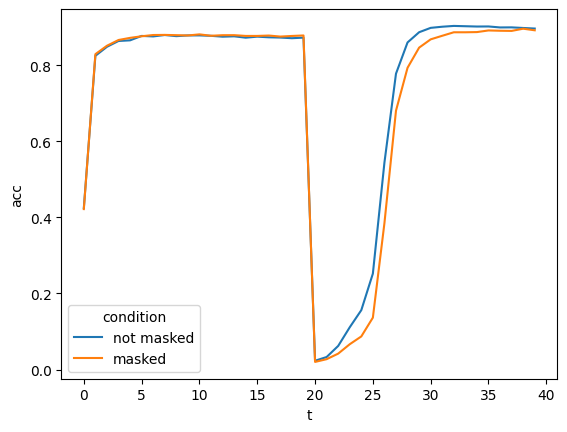

In [ ]:
# _, targets_maskedw, preds_maskedw = get_all_data(model, test_loader)

# condition = {
#     'condition': ['not masked']*seq_len + ['masked']*seq_len, 
#     't': np.concatenate((np.arange(40), np.arange(40))), 
#     'acc': torch.concatenate(((predictions_all.cpu() == targets_all).float().mean(dim=0), (preds_maskedw.cpu() == targets_maskedw).float().mean(dim=0))).numpy()
# }

# df_stim = pd.DataFrame.from_dict(condition)
# sns.lineplot(df_stim, x='t', y='acc', hue='condition')
# plt.show()

## masking weights from class c to class c+1, second stimulus not presented 

In [7]:
# get not masked no show condition 
# reload model to correct weights 
saved_dict = model_result_dict_load(exp_dir + 'onelayer_rec_best.pth.tar')

model.load_state_dict(saved_dict['state_dict'])
model.eval()
hiddens_noshow, targets_noshow, preds_noshow = get_all_data(model, test_loader, onlyshowone=15)

_, targets_all, predictions_all = get_all_data(model, test_loader=test_loader)

torch.cuda.empty_cache()
for i in range(10):
    if i < 9:
        model.r_out_rec.rec_w.weight.data[(i+1)*10:(i+2)*10, i*10:(i+1)*10] = 0
    else:
        model.r_out_rec.rec_w.weight.data[:10, i*10:(i+1)*10] = 0

# get masked no show condition 
_, targets_maskedw_noshow, preds_maskedw_noshow = get_all_data(model, test_loader, onlyshowone=15)

condition_noshow = {
    'condition': ['not masked no show']*seq_len + ['masked no show']*seq_len + ['normal']*seq_len, 
    't': np.concatenate((np.arange(40), np.arange(40), np.arange(40))), 
    'acc': torch.concatenate(((preds_noshow.cpu() == targets_noshow).float().mean(dim=0), (preds_maskedw_noshow.cpu() == targets_maskedw_noshow).float().mean(dim=0), (predictions_all == targets_all).float().mean(dim=0))).numpy()
}

df_conditionnoshow = pd.DataFrame.from_dict(condition_noshow)
sns.lineplot(df_conditionnoshow, x='t', y='acc', hue='condition')
plt.show()

KeyboardInterrupt: 

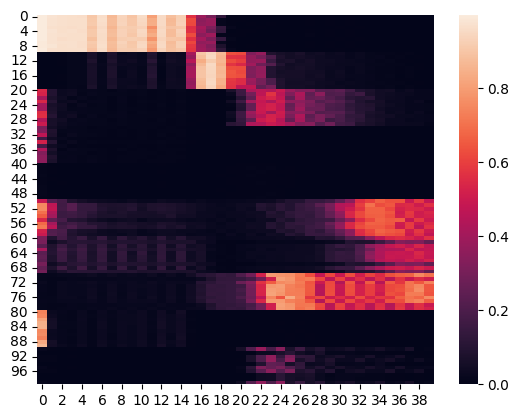

In [9]:
# plot hiddens no show p spk rate 
hiddens_noshow, targets_noshow, preds_noshow = get_all_data(model, test_loader, onlyshowone=15)

p_spk_all = get_states(hiddens_noshow, 5, hidden_dim[0], batch_size, T=40)
sns.heatmap(p_spk_all[seq_test.label_data==0].mean(axis=0).T)
plt.show()


tensor([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 7, 7, 7, 7, 7])

## present wrong stimuli

In [ ]:
# reload model to correct weights 
saved_dict = model_result_dict_load(exp_dir + 'onelayer_rec_best.pth.tar')

model.load_state_dict(saved_dict['state_dict'])
model.eval()

In [ ]:
# let inference run but no input in second half to see if prediction neurons fire anyways 
sample_img1, target1 = testdata[3]
sample_img2, target2 = testdata[6]
print(target2 != target1+1)
stimulus = torch.concatenate((sample_img1.repeat(int(seq_len/2), 1, 1), sample_img2.repeat(int(seq_len/2), 1, 1)))
stimulus.size()

True


torch.Size([40, 28, 28])

In [ ]:
with torch.no_grad():
    model.eval()
    hidden = model.init_hidden(stimulus.view(-1, seq_len, IN_dim).size(0))

    _, hidden, _ = model.inference(stimulus.view(-1, seq_len, IN_dim).to(device), hidden, seq_len)


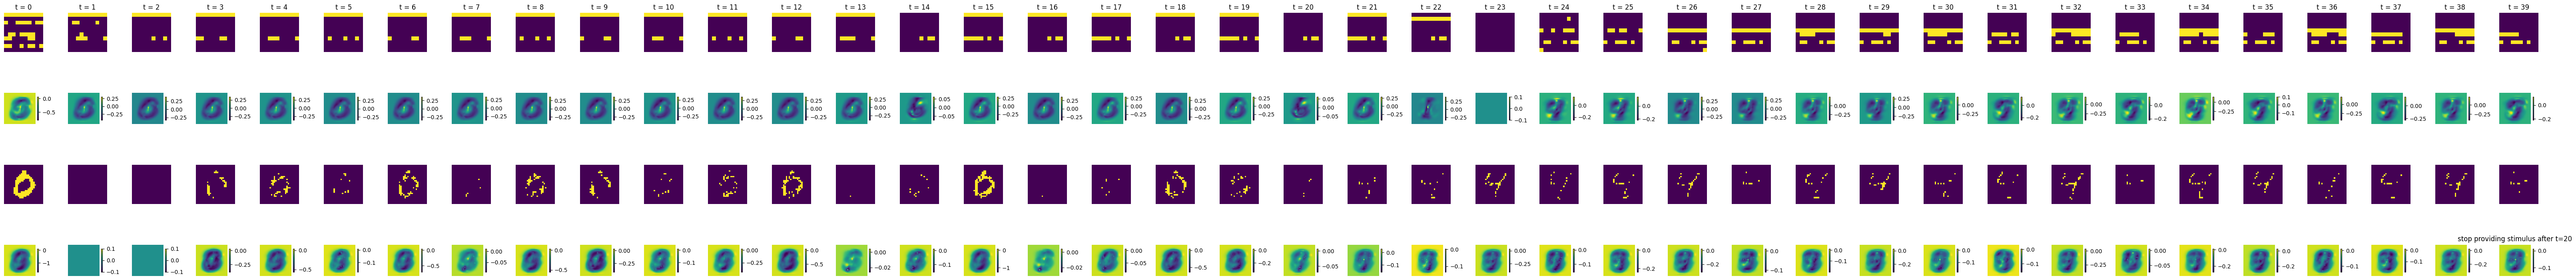

In [ ]:
fig, axs = plt.subplots(4, 40, figsize=(64, 8))  # p spiking, r spiking, rec drive from p, rec drive from r
# axs[0].imshow(images[sample_no, :, :])
# axs[0].set_title('class %i, prediction %i' % (target_all[sample_no], preds_all[sample_no]))
for t in np.arange(0, seq_len):
    # p spiking
    axs[0][t].axis('off')
    axs[0][t].imshow(hidden[t][5][0].detach().cpu().numpy().reshape(10, int(hidden_dim[0] / 10)))
    axs[0][t].set_title('t = %i' % t)

    # drive from p to r
    pos1 = axs[1][t].imshow((p2r_w @ hidden[t][5][0].detach().cpu().numpy()).reshape(28, 28))
    fig.colorbar(pos1, ax=axs[1][t], shrink=0.3)
    axs[1][t].axis('off')

    # r spiking
    axs[2][t].imshow(hidden[t][1][0].detach().cpu().numpy().reshape(28, 28))
    axs[2][t].axis('off')

    # drive from r to r
    pos2 = axs[3][t].imshow((r_rec_w @ hidden[t][1][0].detach().cpu().numpy()).reshape(28, 28))
    fig.colorbar(pos2, ax=axs[3][t], shrink=0.3)
    axs[3][t].axis('off')

plt.title('stop providing stimulus after t=20')
plt.tight_layout()
plt.show()

## compare swtich time to right vs wrong stimuli 

In [ ]:
# use another dataset 
seq_test_unpred = SequenceDataset(testdata, testdata.targets, seq_len, random_switch,
                           switch_time, num_switch)

test_loader_unpred = torch.utils.data.DataLoader(seq_test_unpred, batch_size=batch_size,
                                          shuffle=False, num_workers=3)

for batch_idx, (data, target) in enumerate(test_loader_unpred):
    print(data.shape)
    print(target.shape)
    break

0sequences sampled
1000sequences sampled
2000sequences sampled
3000sequences sampled
4000sequences sampled
num of sequences created: 5000
torch.Size([200, 40, 28, 28])
torch.Size([200, 40])


In [ ]:
_, targets_unpred, preds_unpred = get_all_data(model, test_loader_unpred)


Test set: Average loss: 53.2880, Accuracy: 3393/5000 (68%), End of seq acc: 85.48%



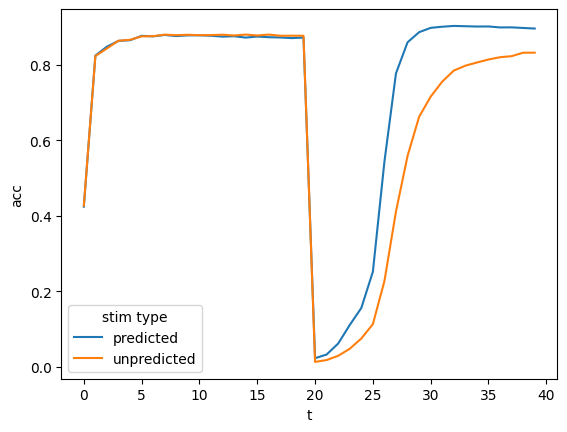

In [ ]:
stim_type = {
    'stim type': ['predicted']*seq_len + ['unpredicted']*seq_len, 
    't': np.concatenate((np.arange(40), np.arange(40))), 
    'acc': torch.concatenate(((predictions_all.cpu() == targets_all).float().mean(dim=0), (preds_unpred.cpu() == targets_unpred).float().mean(dim=0))).numpy()
}

df_stim = pd.DataFrame.from_dict(stim_type)
sns.lineplot(df_stim, x='t', y='acc', hue='stim type')
plt.show()

## MMN 

In [8]:
# different stim for MMN
sample_img1, target1 = testdata[3]
dev_1, dev_target1 = testdata[0]
assert target1 != dev_target1

sample_img2, target2 = testdata[5]
assert target2 == target1+1

dev_2, dev_target2 = testdata[18]
assert target2 != dev_target2

print('target 1 %i, dev1 %i, target2 %i, dev2 %i' % (target1, dev_target1, target2, dev_target2))


target 1 0, dev1 7, target2 1, dev2 3


In [9]:
eg = [7, 2, 11, 10, 2, 8]  # example time 

stimulus_mmn = torch.concatenate(
    # first 20
    (sample_img1.repeat(5, 1, 1), 
    dev_1.repeat(3, 1, 1), 
    sample_img1.repeat(12, 1, 1), 
    # second 20
    sample_img2.repeat(5, 1, 1),
    dev_2.repeat(3, 1, 1), 
    sample_img2.repeat(12, 1, 1)))
stimulus_mmn.size()

torch.Size([40, 28, 28])

In [10]:
with torch.no_grad():
    model.eval()
    hidden = model.init_hidden(stimulus_mmn.view(-1, seq_len, IN_dim).size(0))

    _, hidden, _ = model.inference(stimulus_mmn.view(-1, seq_len, IN_dim).to(device), hidden, seq_len)


In [11]:
# get necessary weights
p2r_w = model.rout2rin.weight.detach().cpu().numpy()
r_rec_w = model.r_in_rec.rec_w.weight.detach().cpu().numpy()

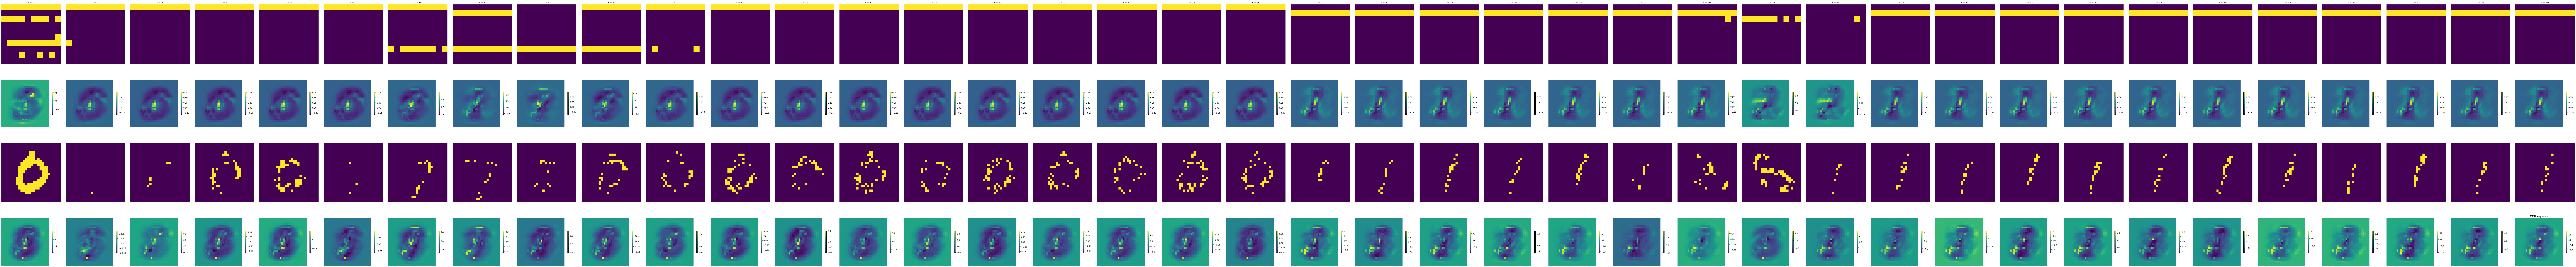

In [12]:
fig, axs = plt.subplots(4, 40, figsize=(180, 20))  # p spiking, r spiking, rec drive from p, rec drive from r
# axs[0].imshow(images[sample_no, :, :])
# axs[0].set_title('class %i, prediction %i' % (target_all[sample_no], preds_all[sample_no]))
for t in np.arange(0, seq_len):
    # p spiking
    axs[0][t].axis('off')
    axs[0][t].imshow(hidden[t][5][0].detach().cpu().numpy().reshape(10, int(hidden_dim[0] / 10)))
    axs[0][t].set_title('t = %i' % t)

    # drive from p to r
    pos1 = axs[1][t].imshow((p2r_w @ hidden[t][5][0].detach().cpu().numpy()).reshape(28, 28))
    fig.colorbar(pos1, ax=axs[1][t], shrink=0.3)
    axs[1][t].axis('off')

    # r spiking
    axs[2][t].imshow(hidden[t][1][0].detach().cpu().numpy().reshape(28, 28))
    axs[2][t].axis('off')

    # drive from r to r
    pos2 = axs[3][t].imshow((r_rec_w @ hidden[t][1][0].detach().cpu().numpy()).reshape(28, 28))
    fig.colorbar(pos2, ax=axs[3][t], shrink=0.3)
    axs[3][t].axis('off')

plt.title('MMN sequence')
plt.tight_layout()
plt.show()

In [13]:
# spking of normal sequence 
stimulus_normal = torch.concatenate(
    # first 20
    (sample_img1.repeat(20, 1, 1), 
     
    # second 20
    sample_img2.repeat(20, 1, 1),))
stimulus_normal.size()

with torch.no_grad():
    model.eval()
    hidden_init = model.init_hidden(stimulus_normal.view(-1, seq_len, IN_dim).size(0))

    _, hidden_normal, _ = model.inference(stimulus_normal.view(-1, seq_len, IN_dim).to(device), hidden_init, seq_len)


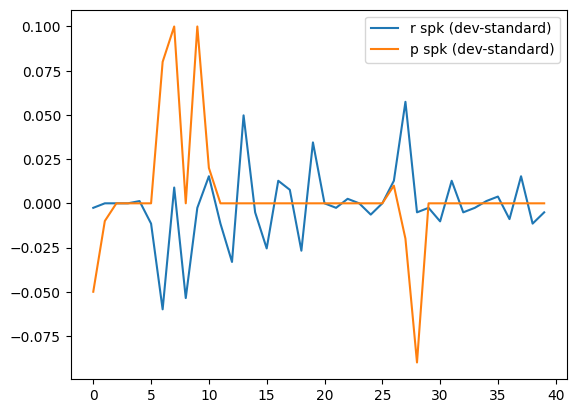

In [14]:
t = np.arange(seq_len)

r_spk_rate_mmn = np.zeros(seq_len)
p_spk_rate_mmn = np.zeros(seq_len)

r_spk_rate_normal = np.zeros(seq_len)
p_spk_rate_normal = np.zeros(seq_len)


for i in range(seq_len):
    r_spk_rate_mmn[i] = hidden[i][1][0].detach().cpu().numpy().mean()
    p_spk_rate_mmn[i] = hidden[i][5][0].detach().cpu().numpy().mean()

    r_spk_rate_normal[i] = hidden_normal[i][1][0].detach().cpu().mean()
    p_spk_rate_normal[i] = hidden_normal[i][5][0].detach().cpu().mean()

plt.plot(t, (r_spk_rate_mmn - r_spk_rate_normal), label='r spk (dev-standard)')
plt.plot(t, (p_spk_rate_mmn - p_spk_rate_normal), label='p spk (dev-standard)')

plt.legend()
plt.show()

In [39]:
testdata.targets

tensor([7, 2, 1,  ..., 4, 5, 6])

In [15]:
# check batch mmn 
batch_mmn = 200

batch_stim = torch.zeros((batch_mmn, seq_len, 28, 28))

for i in range(batch_mmn):
    sample1, label1 = testdata[np.random.choice(10000)]
    dev1, dev_label1 = testdata[np.random.choice(10000)]
    while dev_label1 == label1: 
        dev1, dev_label1 = testdata[np.random.choice(10000)]
    
    if label1 != 9:
        second_label_indices = torch.nonzero(testdata.targets == (label1+1)).squeeze()
        second_label_idx = second_label_indices[np.random.randint(len(second_label_indices))].item()
    else:
        second_label_indices = torch.nonzero(testdata.targets == 0).squeeze()
        second_label_idx = second_label_indices[np.random.randint(len(second_label_indices))].item()
    
    sample2, label2 = testdata[second_label_idx]
    dev2, dev_label2 = testdata[np.random.choice(10000)]
    while dev_label2 == label2: 
        dev2, dev_label2 = testdata[np.random.choice(10000)]

    stimulus_mmn = torch.concatenate(
        # first 20
        (sample1.repeat(5, 1, 1), 
        dev1.repeat(3, 1, 1), 
        sample1.repeat(12, 1, 1), 
        # second 20
        sample2.repeat(5, 1, 1),
        dev2.repeat(3, 1, 1), 
        sample2.repeat(12, 1, 1)))

    batch_stim[i, :, :, :] = stimulus_mmn


with torch.no_grad():
    model.eval()
    hidden_init = model.init_hidden(batch_stim.view(-1, seq_len, IN_dim).size(0))

    _, hidden_mmnb, _ = model.inference(batch_stim.view(-1, seq_len, IN_dim).to(device), hidden_init, seq_len)

In [18]:
spk_p = get_states(hiddens_all, 5, hidden_dim[0], batch_size, T=40, num_samples=seq_test.num_samples)
spk_r = get_states(hiddens_all, 1, hidden_dim[1], batch_size, T=40, num_samples=seq_test.num_samples)


[100, 784]

In [19]:
spk_p_mmn = get_states([hidden_mmnb], 5, hidden_dim[0], batch_size=200, T=40, num_samples=200)
spk_r_mmn = get_states([hidden_mmnb], 1, hidden_dim[1], batch_size=200, T=40, num_samples=200)


In [24]:
r2p_w = model.rin2rout.weight.detach().cpu().numpy()
r2r_w = model.r_in_rec.rec_w.weight.detach().cpu().numpy()
p2p_w = model.r_out_rec.rec_w.weight.detach().cpu().numpy()


r_diff = (spk_r_mmn.mean(axis=0)).mean(axis=1) - (spk_r[:200, :, :].mean(axis=0)).mean(axis=1) 
p_diff = (spk_p_mmn.mean(axis=0)).mean(axis=1) - (spk_p[:200, :, :].mean(axis=0)).mean(axis=1) 


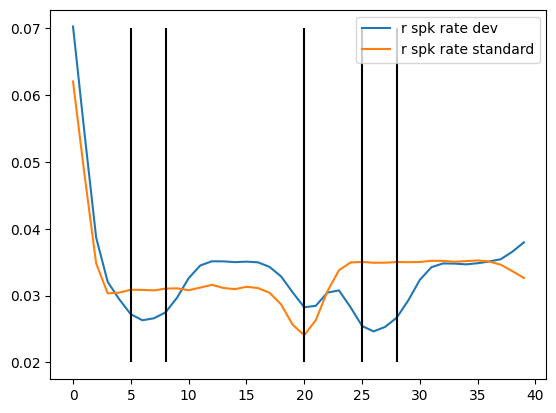

In [38]:
from scipy.ndimage import gaussian_filter
plt.plot(t, gaussian_filter((spk_r_mmn.mean(axis=0)).mean(axis=1), sigma=1.5), label='r spk rate dev')
plt.plot(t, gaussian_filter((spk_r[:200, :, :].mean(axis=0)).mean(axis=1) , sigma=1.5), label='r spk rate standard')
plt.vlines([5, 8, 20, 25, 28], ymin=0.02, ymax=0.07, color='black')
plt.legend()
plt.show()

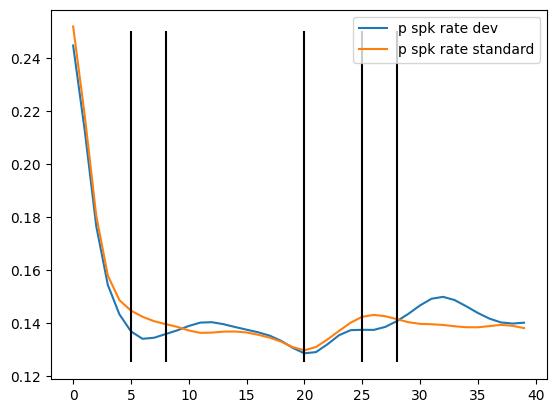

In [40]:
plt.plot(t, gaussian_filter((spk_p_mmn.mean(axis=0)).mean(axis=1), sigma=1.5), label='p spk rate dev')
plt.plot(t, gaussian_filter((spk_p[:200, :, :].mean(axis=0)).mean(axis=1) , sigma=1.5), label='p spk rate standard')
plt.vlines([5, 8, 20, 25, 28], ymin=0.125, ymax=0.25, color='black')
plt.legend()
plt.show()

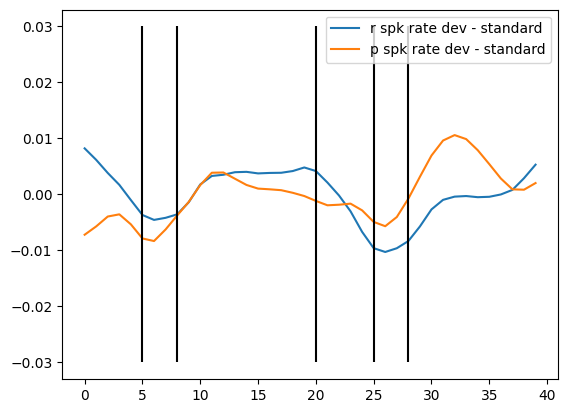

In [33]:
plt.plot(t, gaussian_filter(r_diff, sigma=1.5), label='r spk rate dev - standard')
plt.plot(t, gaussian_filter(p_diff, sigma=1.5), label='p spk rate dev - standard')
plt.vlines([5, 8, 20, 25, 28], ymin=-0.03, ymax=0.03, color='black')
plt.legend()
plt.show()

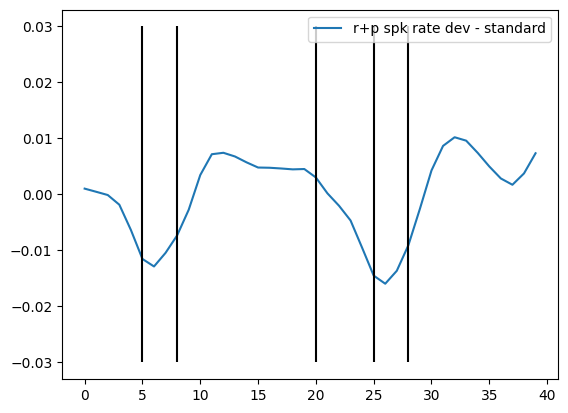

In [41]:
plt.plot(t, gaussian_filter((r_diff + p_diff), sigma=1.5), label='r+p spk rate dev - standard')
plt.vlines([5, 8, 20, 25, 28], ymin=-0.03, ymax=0.03, color='black')
plt.legend()
plt.show()